In [1]:
'''!pip install --upgrade pip
!pip install opencv-python-headless -q
!pip install Pillow -q
!pip install matplotlib -q
!pip install scikit-learn -q
!pip install zipfile -q'''

'!pip install --upgrade pip\n!pip install opencv-python-headless -q\n!pip install Pillow -q\n!pip install matplotlib -q\n!pip install scikit-learn -q\n!pip install zipfile -q'

In [2]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob
import zipfile

2023-09-21 21:49:22.018212: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
files = glob.glob('*.zip')
files

['Data.zip']

In [4]:
'''for file in files:
    print('Unzipping:',file)

    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('')'''

Unzipping: Data.zip


-----

In [4]:
image_directory = 'Data/Segments/'
mask_directory = 'Data/Masks/'

In [5]:
image_names = glob.glob("Data/Segments/*.png")
print(len(image_names))

197


In [6]:
SIZE = 512
num_images = 100

In [7]:
image_names.sort()

In [8]:
image_names_subset = image_names[0:num_images]

In [9]:
images = [cv2.imread(img, 0) for img in image_names_subset]

In [10]:
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

In [11]:
mask_names = glob.glob("Data/Masks/*.png")
mask_names.sort()

mask_names_subset = mask_names[0:num_images]

masks = [cv2.imread(mask, 0) for mask in mask_names_subset]

mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [12]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (100, 512, 512, 1)
Mask data shape is:  (100, 512, 512, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


In [13]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = mask_dataset /255.  #PIxel values will be 0 or 1

In [14]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (100, 512, 512, 1)
Mask data shape is:  (100, 512, 512, 1)
Max pixel value in image is:  1.0
Labels in the mask are :  [0. 1.]


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    image_dataset,
    mask_dataset,
    test_size = 0.20,
    random_state = 42)

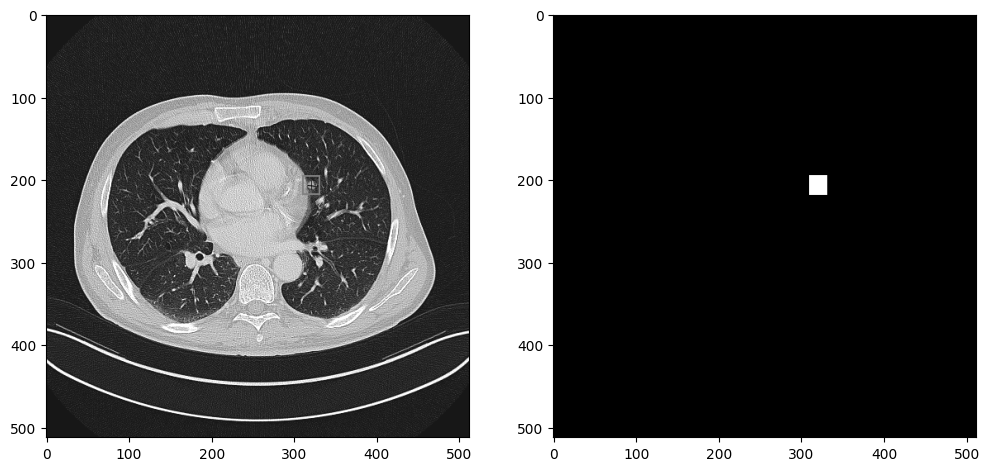

In [16]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()


In [17]:
# Building Unet by dividing encoder and decoder into blocks
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x


#Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


#Decoder block
#skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [18]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

print(IMG_HEIGHT)
print(IMG_WIDTH )
print(IMG_CHANNELS)

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

512
512
1


In [34]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 512, 512, 64)         640       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 512, 512, 64)         256       ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_18 (Activation)  (None, 512, 512, 64)         0         ['batch_normalizat

In [20]:
!nvidia-smi

Thu Sep 21 21:50:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 30%   37C    P2   102W / 350W |  22722MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [35]:
history = model.fit(X_train, y_train,
                    batch_size = 8,
                    verbose=1,
                    epochs=20,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/20
10/10 [==============================] - 17s 509ms/step - loss: 0.5067 - accuracy: 0.8448 - val_loss: 0.6852 - val_accuracy: 0.9898
Epoch 2/20
10/10 [==============================] - 4s 449ms/step - loss: 0.3611 - accuracy: 0.9714 - val_loss: 0.6710 - val_accuracy: 0.9943
Epoch 3/20
10/10 [==============================] - 4s 451ms/step - loss: 0.2711 - accuracy: 0.9901 - val_loss: 0.6471 - val_accuracy: 0.9967
Epoch 4/20
10/10 [==============================] - 4s 453ms/step - loss: 0.2165 - accuracy: 0.9955 - val_loss: 0.6143 - val_accuracy: 0.9967
Epoch 5/20
10/10 [==============================] - 4s 454ms/step - loss: 0.1786 - accuracy: 0.9963 - val_loss: 0.5746 - val_accuracy: 0.9967
Epoch 6/20
10/10 [==============================] - 4s 454ms/step - loss: 0.1512 - accuracy: 0.9964 - val_loss: 0.5297 - val_accuracy: 0.9967
Epoch 7/20
10/10 [==============================] - 5s 455ms/step - loss: 0.1341 - accuracy: 0.9965 - val_loss: 0.5311 - val_accuracy: 0.9961
Epoch

In [36]:
#Save the model for future use
model.save('20epochs-lr4.hdf5')

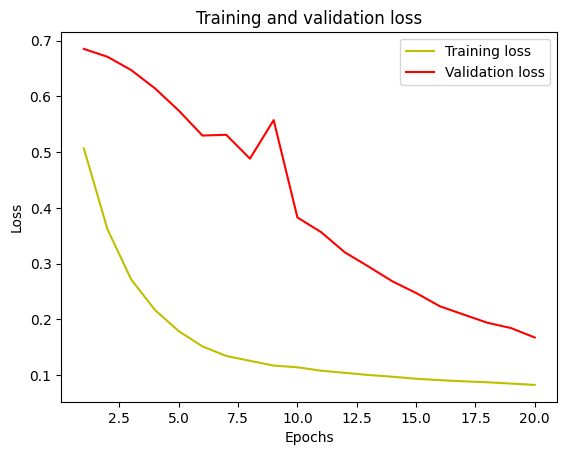

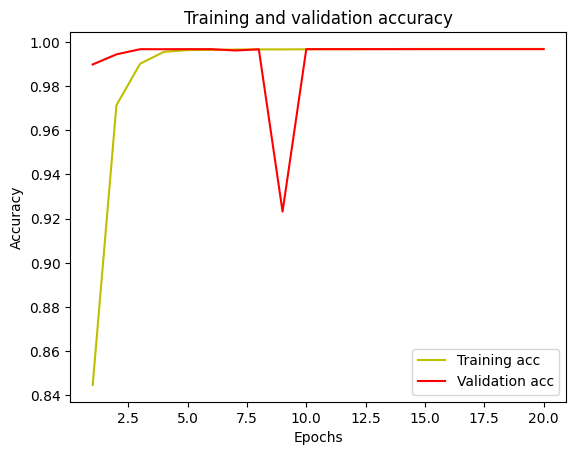

In [37]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [38]:
#Load previously saved model
from keras.models import load_model
model = load_model('20epochs-lr4.hdf5')

In [39]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

1/1 [==============================] - 0s 451ms/step


In [40]:
from tensorflow.keras.metrics import MeanIoU

In [41]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())


Mean IoU = 0.49835032


(1, 512, 512, 1)
1/1 [==============================] - 0s 29ms/step
(512, 512)


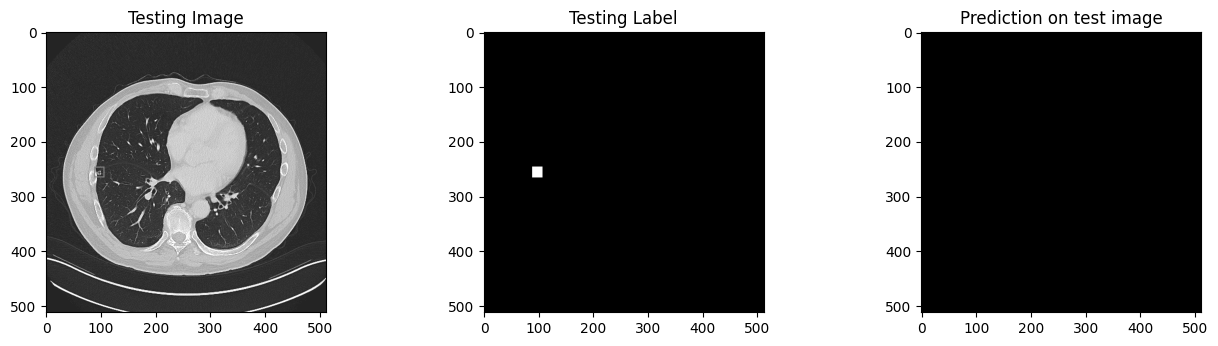

In [49]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()